<a href="https://colab.research.google.com/github/pramod1997/FantasyLord/blob/master/carrer_con_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip career-con-2019.zip

Archive:  career-con-2019.zip
  inflating: X_test.csv              
  inflating: y_train.csv             
  inflating: sample_submission.csv   
  inflating: X_train.csv             


In [0]:
import pandas as pd
import numpy as np

In [0]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')



In [0]:
X_train.head()

In [0]:
X_train['measurement_number'].unique()  ## 128 observation/experiment  for each series id 

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [0]:
X_train['series_id'].unique()   #### 3810 observation which have label

array([   0,    1,    2, ..., 3807, 3808, 3809])

In [0]:
### what is group id
import seaborn as sns
list(sorted(Y_train['group_id'].unique()))  ### contains output from 0 -72 :: 73 groups 

In [0]:
### need to find relation between groups and others 

### info from kaggle 
#shows that for each groupid, there is only one type of surface. That means, for one groupid, 
#they drove the robot on the 
#same surface (or similar) for multiple times (i.e. multiple series_id) and captured the data.

In [0]:
### multi label classifier to be used 
### cv strategy  --> k fold , stratified k fold 

### feature engineering using concopt of physics



In [0]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [0]:
X_train = fe(X_train)
X_test = fe(X_test)
X_train.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,...,8090.592033,2.278501e+06,6.255962e+05,9.597909e+06,1.409996e+06,15.342019,1.198969e+06,8924.000999,9.597909e+06,6.255962e+05
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,...,2339.913394,4.613413e+05,1.377975e+05,1.957088e+06,2.979271e+05,14.202636,2.049951e+05,569.164381,1.957088e+06,1.377975e+05
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,...,22485.416514,5.372327e+06,1.674839e+06,2.866679e+07,3.802655e+06,17.116144,2.355426e+06,-9135.272306,2.866679e+07,1.674839e+06
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.000026,-6.349206e-07,0.93968,0.93884,0.310140,...,2157.840573,4.765087e+05,8.652378e+04,3.121275e+06,4.627398e+05,36.074189,2.981020e+05,17412.401283,3.121275e+06,8.652378e+04
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.000080,7.936508e-08,0.89689,0.88673,0.428144,...,4804.885067,3.694817e+05,2.330043e+05,6.165090e+05,9.199986e+04,2.645912,2.281891e+04,-70.793166,6.165090e+05,2.330043e+05


In [0]:
import seaborn as sns
len(X_train.index), len(X_test.index)


(3810, 3816)

In [0]:
### heirarchichal access it index
X_train.index
X_train.columns

Index(['orientation_X_mean', 'orientation_X_min', 'orientation_X_max',
       'orientation_X_std', 'orientation_X_max_to_min',
       'orientation_X_mean_abs_change',
       'orientation_X_mean_change_of_abs_change', 'orientation_X_abs_max',
       'orientation_X_abs_min', 'orientation_Y_mean',
       ...
       'angle_vs_acc_abs_min', 'angle_vs_vel_mean', 'angle_vs_vel_min',
       'angle_vs_vel_max', 'angle_vs_vel_std', 'angle_vs_vel_max_to_min',
       'angle_vs_vel_mean_abs_change',
       'angle_vs_vel_mean_change_of_abs_change', 'angle_vs_vel_abs_max',
       'angle_vs_vel_abs_min'],
      dtype='object', length=171)

In [0]:
Y_train['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [0]:
dict = {'fine_concrete':0 , 'concrete':1, 'soft_tiles':2, 'tiled':3, 'soft_pvc':4,
       'hard_tiles_large_space':5, 'carpet':6, 'hard_tiles':7, 'wood':8}

Y_train['surface'].replace(dict, inplace = True)

In [0]:
### now we create models 

In [0]:
### models :::: multi class labels 

## 1 . knn 
## 2 . logistic 
## 3 . random forest
## 4 . xgboost --> gets highest weith
## 5 . bgm 



In [0]:
X_train.columns

Index(['orientation_X_mean', 'orientation_X_min', 'orientation_X_max',
       'orientation_X_std', 'orientation_X_max_to_min',
       'orientation_X_mean_abs_change',
       'orientation_X_mean_change_of_abs_change', 'orientation_X_abs_max',
       'orientation_X_abs_min', 'orientation_Y_mean',
       ...
       'angle_vs_acc_abs_min', 'angle_vs_vel_mean', 'angle_vs_vel_min',
       'angle_vs_vel_max', 'angle_vs_vel_std', 'angle_vs_vel_max_to_min',
       'angle_vs_vel_mean_abs_change',
       'angle_vs_vel_mean_change_of_abs_change', 'angle_vs_vel_abs_max',
       'angle_vs_vel_abs_min'],
      dtype='object', length=171)

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import lightgbm as gbm




In [0]:
### knn needs some LDA or PCA on the data befreo making prediction 
### ensemble models are not affected by cdorrelated features

In [0]:
## grid search -----> DO THIS TO GET THE MODEL FOR XGBOOST
from sklearn.model_selection import GridSearchCV
model = xgb.XGBClassifier(objective='multi:softprob', nthread=4,  seed=39)

params = {  'learning_rate':[0.1,0.01, 0.5], 
             'n_estimators':[100,200], 
              'max_depth':[5,10,15],
               
              'gamma':[1,0.1,0.01]                        
          }
clf  = GridSearchCV( model ,params,cv =5   )
clf.fit(X_train, Y_train['surface'])
clf.best_params_

KeyboardInterrupt: ignored

In [0]:
val_scores = []
train_scores = []
kf = KFold(n_splits = 5 , shuffle =True , random_state = 3939)
i =0 
for (train_index , val_index) in kf.split(X_train ,Y_train['surface']) :
  print("FOLD -",i)
  i = i+1
  X_train_set  , Y_train_set = X_train.iloc[train_index] , Y_train['surface'].iloc[train_index]
  X_val_set , Y_val_set = X_train.iloc[val_index] , Y_train['surface'].iloc[val_index]
  
  model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, gamma=3, 
                        objective='multi:softprob', nthread=4,  seed=3939)
  #model = RandomForestClassifier(n_estimators = 200 , n_jobs =-1)
  #model = KNeighborsClassifier(n_neighbors = 5)  -> need LDA or PCA 
  #model = LogisticRegression(solver = 'lbfgs', max_iter = 4000 , multi_class = 'multinomial')
  model.fit(X_train_set,Y_train_set)
  
  print('train_score->' , accuracy_score(Y_train_set, model.predict(X_train_set)) , 'val_score-->' , accuracy_score(Y_val_set, model.predict(X_val_set)))
    #val_scores.append(accuracy_score(Y_val_set, knn.predict(X_val_set)))
    #train_scores.append(accuracy_score(Y_train_set, knn.predict(X_train_set)))

FOLD - 0
train_score-> 0.9763779527559056 val_score--> 0.8818897637795275
FOLD - 1
train_score-> 0.9740813648293963 val_score--> 0.8858267716535433
FOLD - 2
train_score-> 0.9776902887139107 val_score--> 0.8569553805774278
FOLD - 3
train_score-> 0.972769028871391 val_score--> 0.8674540682414699
FOLD - 4
train_score-> 0.9776902887139107 val_score--> 0.884514435695538


In [0]:
# light gmb submission ---> to be ensembled with xgboost , rf with trained hyperparameters

In [0]:
xgb_pred

array(['tiled', 'carpet', 'tiled', ..., 'concrete', 'concrete', 'wood'],
      dtype=object)

In [0]:
xgb_pred = model.predict(X_test)
# encode the prediction 
decode_dict = {0:'fine_concrete' , 1:'concrete', 2:'soft_tiles', 3:'tiled', 4:'soft_pvc',
       5:'hard_tiles_large_space', 6:'carpet', 7:'hard_tiles', 8:'wood'}

xgb_pred = [decode_dict[x] for x in xgb_pred]
xgb_pred[:5]


['tiled', 'carpet', 'tiled', 'carpet', 'soft_tiles']

In [0]:
xgb_v1 = pd.DataFrame({'series_id':X_test.index , 'surface':xgb_pred})
xgb_v1.to_csv('xgb_v1.csv',index = False)

### this code outputs the prediction from rf which uses 200 n_estimators 
### probably overfits


In [0]:
df1 = pd.read_csv('xgb_v1.csv')
df2 = pd.read_csv('rf_kaggle.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


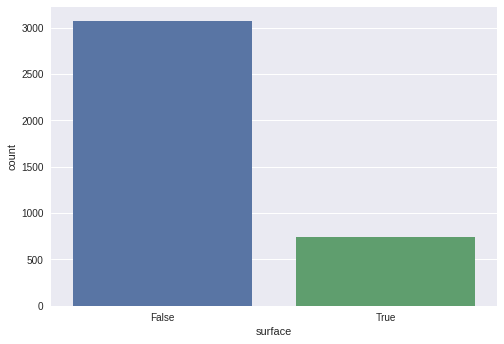

In [0]:
import seaborn as sns

sns.countplot(((df1.surface != df2.surface)))
